In [1]:
import MDAnalysis as mda
import numpy as np
import sys
import matplotlib.pyplot as plt
#nav = mda.units.N_Avogadro

from datetime import date
today = date.today()

import yaml
import os
import fnmatch

import time
import gc
gc.collect()


/home/nenciric/anaconda3/envs/all3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0

In [2]:
pwd

'/home/local/nenciric/Documents/git/charged_molecules_binding/figure_density_profile'

In [49]:
class FormFactor(object):
    """
    Calculates form factors from density profiles.
    
    Further development will include thickness of the membrane 
    from the intersection of lipid density and water density.
    Already enables to calculate electrom/mass/number densities
    
    Density could be calculated only from the final form factor profile 
    - testing is needed to see stability for rare species.
    
    Examination of FF error spikes is needed!
    
    """
    def __init__(self, path,name,nbin,bsize,output,center,group,density_type="electron"):
        
        readme = path+name+ "/README.yaml"
        with open(readme) as yaml_file:
            content = yaml.load(yaml_file, Loader=yaml.FullLoader)
        self.readme=content
        
        self.conf = path+name+'/'+content["FILES"]["gro"]["NAME"]
        self.traj = path+name+'/'+content["FILES"]["xtc"]["NAME"]
        start_time=time.time()
        self.wholeUNI = mda.Universe(self.conf,self.traj)
        
        print("Loading the trajectory takes {:10.6f} s".format(time.time()-start_time))
        
        #group to calculate  mass or number densities - should be extended to more than 1 group!
        self.u = self.wholeUNI.select_atoms(group)
        self.group=group
        
        
        #the totatl box size in [nm] - will be probably removed and tpr box size or 
        #transform of final FF will be used instead
        self.bsize = bsize
        self.output = output
        self.center = center
        
        
        
        
        
        
        self.density_type = density_type
        
        self.calculate_weight()
        

        self.calculate_density()
        
    def calculate_weight(self):
        """
        Creates an array of weights for all atoms in the simulation.
        
        For electron densities:
         - creates dictonary of atom types and number of electrons
           loaded form an external file --> in the future it backmaps 
                                            the atom names to mapping files
                                            and automaticaly assigns # of electrons
                                            
        Number densities:
         - all weights are 1
         
        Mass densities:
         - reads masses from u.atoms.masses
        """
        start_time=time.time()
        if self.density_type=="electron":
            with open ('electrons.dat') as f:
                rawdata = f.read().split('\n')
                lines= rawdata[0:len(rawdata)-1]
                tmp_atoms = np.asarray([l.split()[0:2] for l in lines])
                electrons = dict([ (elem[0],int(elem[1])) for elem in tmp_atoms])
        
            #weights to calculate the electron density
            wght=np.zeros(self.u.atoms.names.shape[0])
            for i in range (0,self.u.atoms.names.shape[0]):
                wght[i]=electrons[self.u.atoms.names[i]]
            self.wght=wght
        if self.density_type=="number":
            self.wght=np.ones(self.u.atoms.names.shape[0])
        if self.density_type=="mass":
            self.wght=self.u.atoms.masses
            
        print("Creating the electron mapping dictonary takes {:10.6f} s".format(time.time()-start_time))

    def calculate_density(self):

        
        c = self.wholeUNI.select_atoms(self.center)

        
       
        
        
        box_z = self.u.dimensions[2]

 
        min_z = box_z   # used to search for the min box size to cut off the profile on the edges

        self.nbin=int(box_z*3)
        boxH = box_z/10
        d = boxH/ self.nbin


        x = np.linspace(-boxH/2,boxH/2,self.nbin+1)[:-1] + d/2
        fx = np.zeros(self.nbin)
        fa=[]
        fb=[]

        """Calculte density profiles and FF from individual frames"""
        start_time=time.time()
        begin_analysis=int(int(self.readme['BINDINGEQ'])/int(self.readme["FILES"]['xtc']['TIMESTEP']))
        beginning_time=begin_analysis #self.uni.trajectory.time
        for ts in self.wholeUNI.trajectory[begin_analysis:begin_analysis+20]:
            #count the index of the frame, numbered from 0, used to be used for the density profile averaging
            #posible not needed now
            frame = ts.frame
            end_time = ts.time
            

            
            #reads the dimension in z-direction
            box_z = ts.dimensions[2]
            if box_z/10<min_z:
                min_z=box_z/10
            
            #print(min_z)

            #deal with the one problematic simulation
            self.problem="no"
            if self.problem=="yes":
                crds = self.wholeUNI.atoms.positions+100
                self.wholeUNI.atoms.positions= crds
                self.wholeUNI.atoms.pack_into_box()

                self.c = self.wholeUNI.select_atoms("resname POPC")
                self.u = self.wholeUNI.select_atoms(self.group)

                
            c = self.wholeUNI.select_atoms("resname POPC")

            
            #reads the coordinates of all of the atoms [angstroms]
            crds = self.u.atoms.positions
            
            ##plot
            vbin = d*np.prod(ts.dimensions[:2])/100
            one_frame_density=np.histogram(crds[:,2]/10,bins=self.nbin,range=(-boxH/2,boxH/2),weights=self.wght/vbin)[0]
            density_data = np.vstack((x,one_frame_density)).transpose()
            self.plot_density(density_data)
            
            print("The shape of the density data is {}".format(density_data.shape))
            
            
            #calculates the center of mass of the selected atoms that the density should be centered around and 
            #takes the z-coordinate value, [angstroms]
            ctom = c.atoms.center_of_mass()[2]
            
            i=int(density_data.shape[0]/2)-1
            print("The index corresponding to 0 in the normal is {}".format(i))
            print("The zero point is {}".format(density_data[i,0]))
            first=0
            first_list=[]
            while density_data[i,0]<ctom/10:
                first+=density_data[i,1]
                first_list.append(first)
                
                i+=1
                
            #print(first_list)
            print("The first half is {}".format(first))
            print("The index after the first half is {}".format(i))
            print("The normal coordinate corresponding to this index {}".format(density_data[i,0])) 
            print("The center of mass {}".format(ctom))
            print(len(first_list))
            
            first=0
            first_list=[]
            i-=1
            while density_data[i,1]>0: #<ctom*2/10:
                first+=density_data[i,1]
                first_list.append(first)
                
                i+=1
                
            #print(first_list)
            print("The second half is {}".format(first))
            print("The index after the second half is {}".format(i))
            print("The normal coordinate corresponding to this index {}".format(density_data[i,0])) 
            print(len(first_list))
            
            #moves the center of mass of the selected centering group into box/2
            crds[:,2] += box_z/2 - ctom
            
            """shifts the coordinates in the universe by the value of the center of mass"""
            self.u.atoms.positions = crds
            
            """puts the atoms back to the original box dimension; it possibly does not take PBC into account
            #therefore it may brake some of the water molecules; try it, come to the issue later"""
            self.u.atoms.pack_into_box()
            
            """shif the coordinates so that the center in z-dimention is in 0; 
            #divide by 10 to get the coordinates in nm, since now the crds are only the z coordinates"""
            crds = (self.u.atoms.positions[:,2] - box_z/2)/10
            
            #gets the box-z size in nm
            box_z /= 10
            
            """calculates the volume of the bin; d- the "height" of a bin; assumes in [nm] """
            # ts.dimension[0], ts.dimension[1] - the x and y dimension; in [A] --> devides by 100
            vbin = d*np.prod(ts.dimensions[:2])/100
            
            #start_time2=time.time()

            
            one_frame_density=np.histogram(crds,bins=self.nbin,range=(-boxH/2,boxH/2),weights=self.wght/vbin)[0]
            density_data = np.vstack((x,one_frame_density)).transpose()
            self.plot_density(density_data)
            
            i=0
            minus=0
            while i<len(x)/2+1:
                minus+=one_frame_density[i]
                i+=1

            print(i)
            plus=0
            while i<len(x):
                plus+=one_frame_density[i]
                i+=1
    

            print(minus)
            print(plus)
            print(i)
            

            """calculates the total density profile; keep for now"""
            fx += np.histogram(crds,bins=self.nbin,range=(-boxH/2,boxH/2),weights=self.wght/vbin)[0]
           
        print("Calculating the density takes {:10.6f} s".format(time.time()-start_time))


        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        """ Normalizing the profiles """
        fx /= (frame+1-begin_analysis) 
        
        

        """ Symmetrizing profile if necessary """
        #if args.symmetrize :
            #fx += fx[::-1]
            #fx /=2


        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        """ Post-processign data and writing to file """
        density_data = np.vstack((x,fx)).transpose()
        
        
        """Post-processing of FF data from individual runs"""
        
        
    
        
        
       
        """Get the indexes of the final density data where all the time steps contribute
        In other words, take the coordinates of the smalest box from the simulation"""
        final_FF_start=int(np.round(self.nbin/2-min_z/d/2))+1
        final_FF_end=int(np.round(self.nbin/2+min_z/d/2))-1
        
  
        
       
        """Plot density profiles from the average density with minimal box"""
        self.plot_density(density_data[final_FF_start:final_FF_end,:])
        self.plot_density(density_data)
        
        
        with open(str(self.output)+".finalDensity", 'w') as f:
            f.write("# Density profile calculated from '{}'\n".format(self.traj))
            f.write("# Density profile of '{}'\n".format(self.group))
            f.write("# Density centered around '{}'\n\n".format(self.center))
            
            f.write("# Beginning time: {} ns \n# End time: {} ns \n".format(beginning_time/1000,end_time/1000))
            f.write("# Time Step: {} ns \n\n".format(self.wholeUNI.trajectory[2].time/1000-self.wholeUNI.trajectory[1].time/1000))
            
            f.write("# Analyzed by R Nencini, ricky.nencini@helsinki.fi / nencini.ricky@gmail.com \n")
            f.write("# Analyzed on '{}'\n\n".format(today))

            
            #np.savetxt(f, density_data,fmt='%8.4f  %.8f')
            np.savetxt(f, density_data[final_FF_start+1:final_FF_end-1,:],fmt='%8.4f  %.8f')
        
        """Save data into files"""
        
        
        
    def plot_density(self,data):
        #data=np.loadtxt(self.output)
        plt.figure(figsize=(15, 6))
        plt.plot(data[:,0],data[:,1])
        plt.xlabel("Membrane normal [nm]")
        plt.show()
        

    
   
        

 
               



Loading the trajectory takes   3.391619 s
Creating the electron mapping dictonary takes   0.000035 s


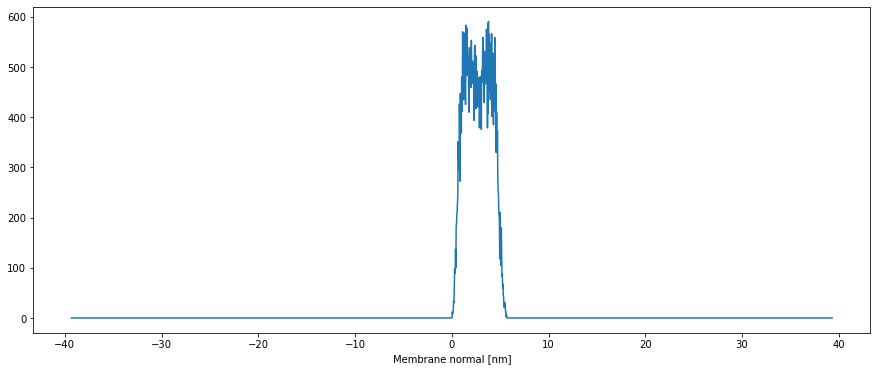

The shape of the density data is (2360, 2)
The index corresponding to 0 in the normal is 1179
The zero point is -0.016672368453724013
The first half is 32169.5061362256
The index after the first half is 1264
The normal coordinate corresponding to this index 2.817630268678828
The center of mass 28.139615663550067
85
The second half is 30756.007398988146
The index after the second half is 1352
The normal coordinate corresponding to this index 5.7519671165337005
89


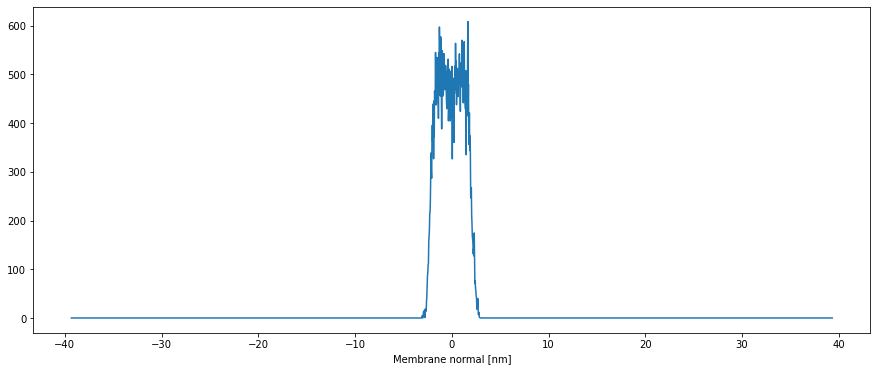

1181
32879.61772655255
29650.21981771187
2360


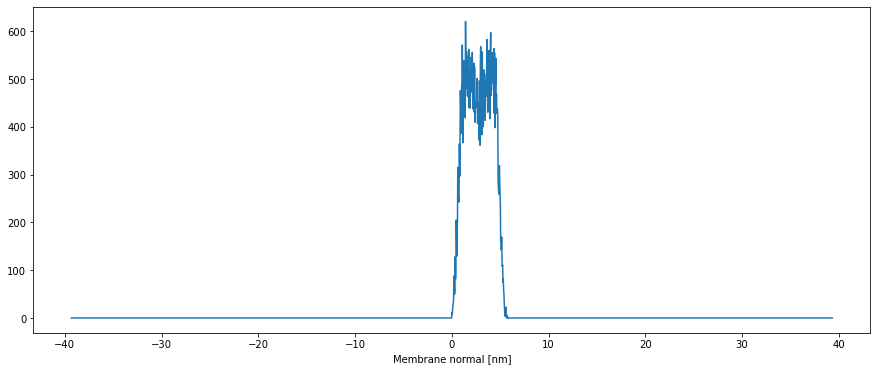

The shape of the density data is (2360, 2)
The index corresponding to 0 in the normal is 1179
The zero point is -0.016672368453724013
The first half is 32850.40073606806
The index after the first half is 1266
The normal coordinate corresponding to this index 2.8843197424937106
The center of mass 28.573897127897123
87
The second half is 31775.510470496378
The index after the second half is 1352
The normal coordinate corresponding to this index 5.7519671165337005
87


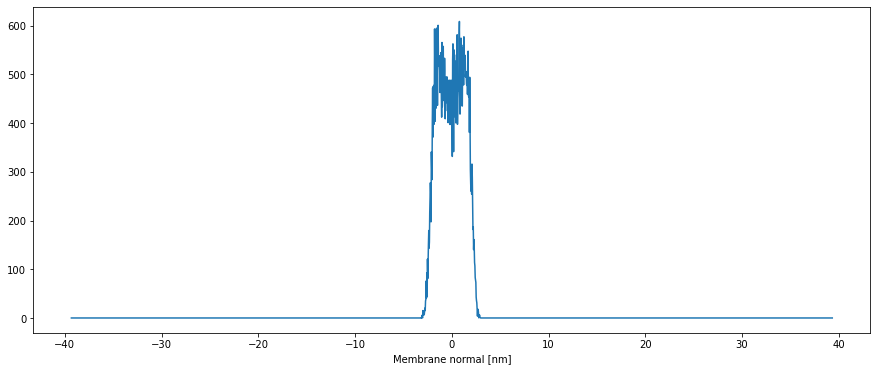

1181
33178.736760756234
30997.643594127865
2360


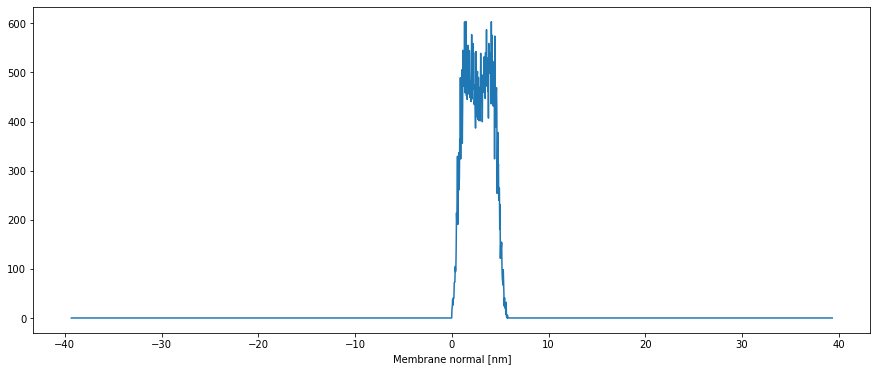

The shape of the density data is (2360, 2)
The index corresponding to 0 in the normal is 1179
The zero point is -0.016672368453724013
The first half is 31981.01086891899
The index after the first half is 1264
The normal coordinate corresponding to this index 2.817630268678828
The center of mass 28.025035705762587
85
The second half is 31541.51479981221
The index after the second half is 1351
The normal coordinate corresponding to this index 5.718622379626256
88


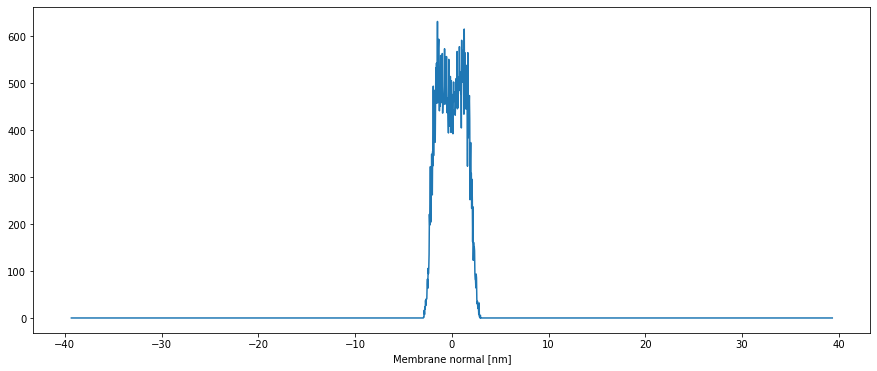

1181
32501.777544611617
30652.785144677175
2360


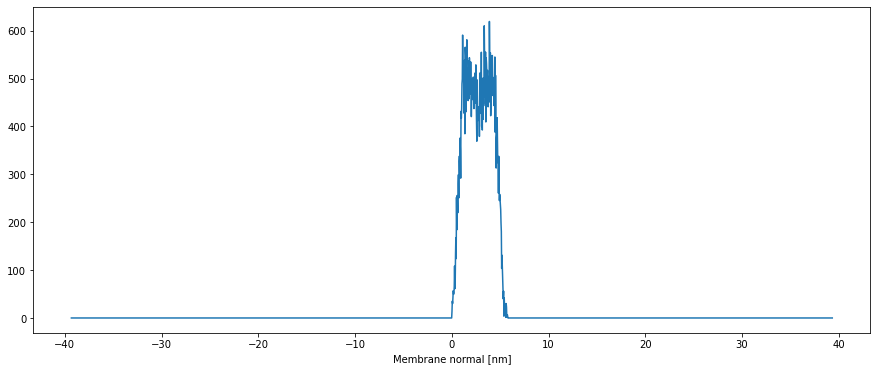

The shape of the density data is (2360, 2)
The index corresponding to 0 in the normal is 1179
The zero point is -0.016672368453724013
The first half is 32397.712456913683
The index after the first half is 1265
The normal coordinate corresponding to this index 2.8509750055862657
The center of mass 28.28810852496707
86
The second half is 31553.287420877827
The index after the second half is 1355
The normal coordinate corresponding to this index 5.852001327256028
91


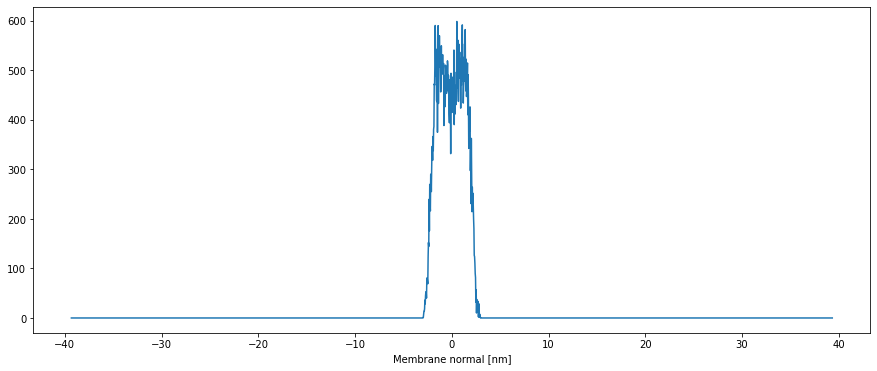

1181
32766.400202979697
30784.99620374002
2360


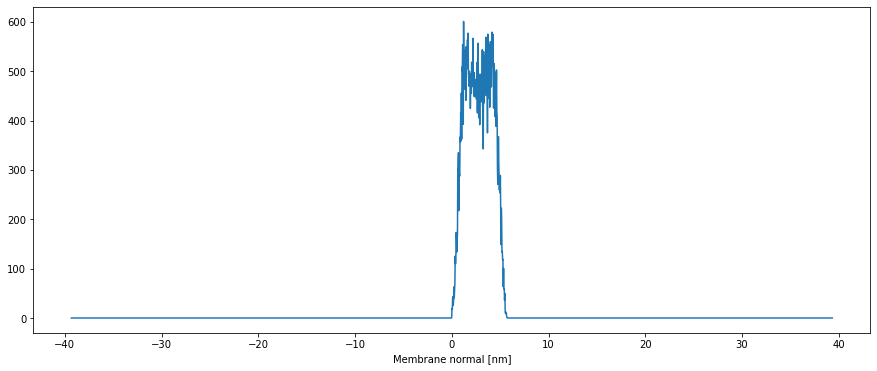

The shape of the density data is (2360, 2)
The index corresponding to 0 in the normal is 1179
The zero point is -0.016672368453724013
The first half is 32419.752219037717
The index after the first half is 1265
The normal coordinate corresponding to this index 2.8509750055862657
The center of mass 28.414672918932297
86
The second half is 32401.084983894616
The index after the second half is 1353
The normal coordinate corresponding to this index 5.785311853441138
89


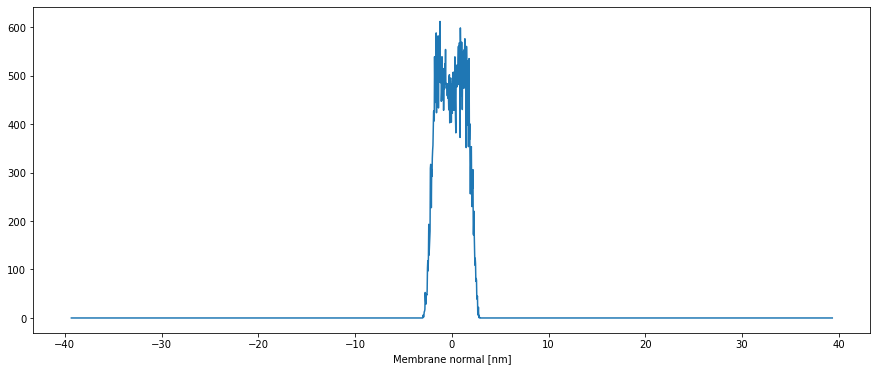

1181
32973.26069586951
31379.404688008886
2360


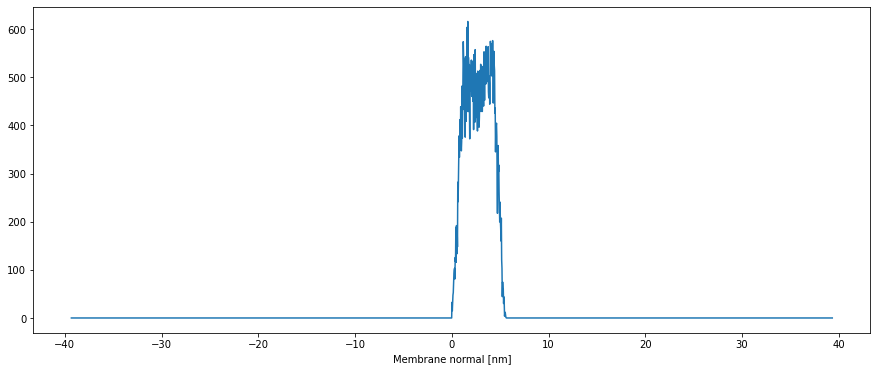

The shape of the density data is (2360, 2)
The index corresponding to 0 in the normal is 1179
The zero point is -0.016672368453724013
The first half is 32243.37874562811
The index after the first half is 1265
The normal coordinate corresponding to this index 2.8509750055862657
The center of mass 28.220144929008892
86
The second half is 31484.008163684914
The index after the second half is 1349
The normal coordinate corresponding to this index 5.651932905811373
85


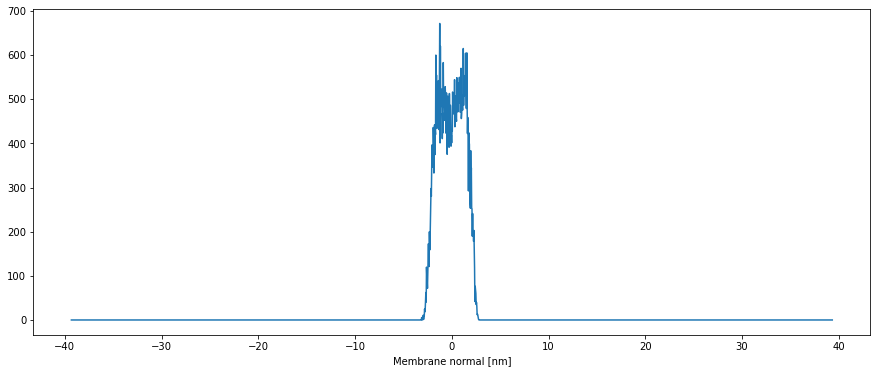

1181
32548.81846702374
30826.016423049736
2360


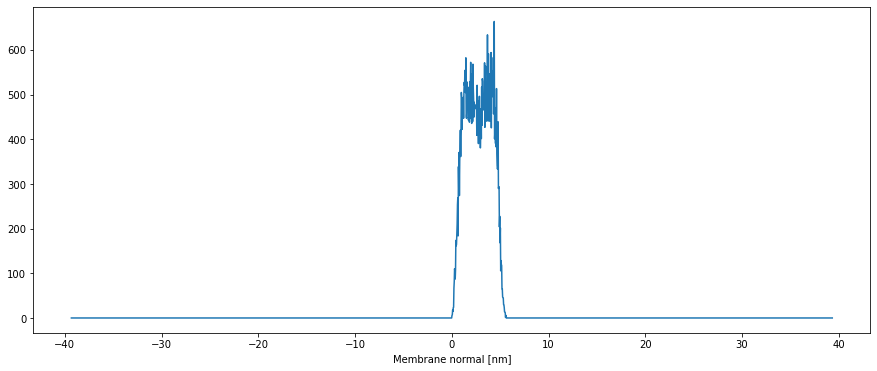

The shape of the density data is (2360, 2)
The index corresponding to 0 in the normal is 1179
The zero point is -0.016672368453724013
The first half is 32145.98618655581
The index after the first half is 1264
The normal coordinate corresponding to this index 2.817630268678828
The center of mass 27.89766859329157
85
The second half is 31848.636542205426
The index after the second half is 1350
The normal coordinate corresponding to this index 5.685277642718818
87


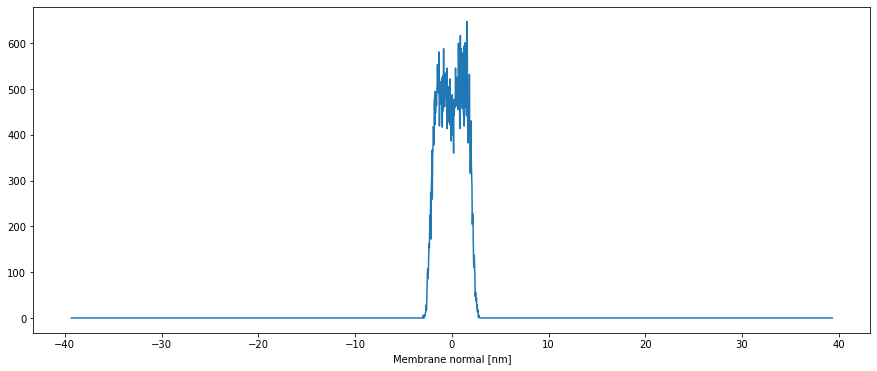

1181
32467.57354517555
31060.654447517514
2360


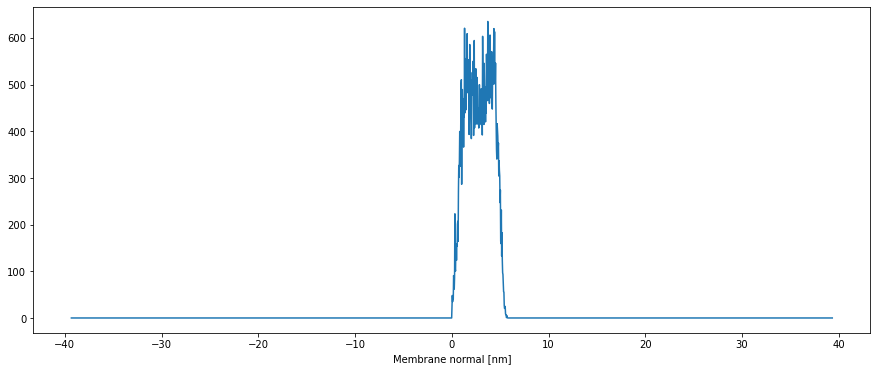

The shape of the density data is (2360, 2)
The index corresponding to 0 in the normal is 1179
The zero point is -0.016672368453724013
The first half is 33594.31020797933
The index after the first half is 1268
The normal coordinate corresponding to this index 2.9510092163085933
The center of mass 29.318725482819627
89
The second half is 31485.047706812577
The index after the second half is 1353
The normal coordinate corresponding to this index 5.785311853441138
86


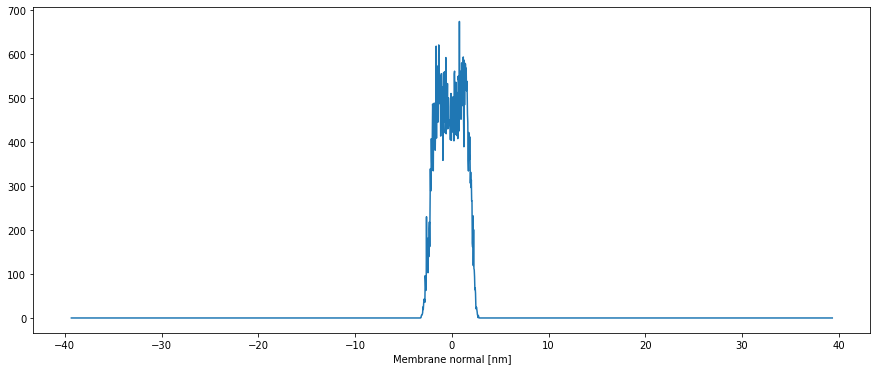

1181
34099.78456548123
30614.947365270666
2360


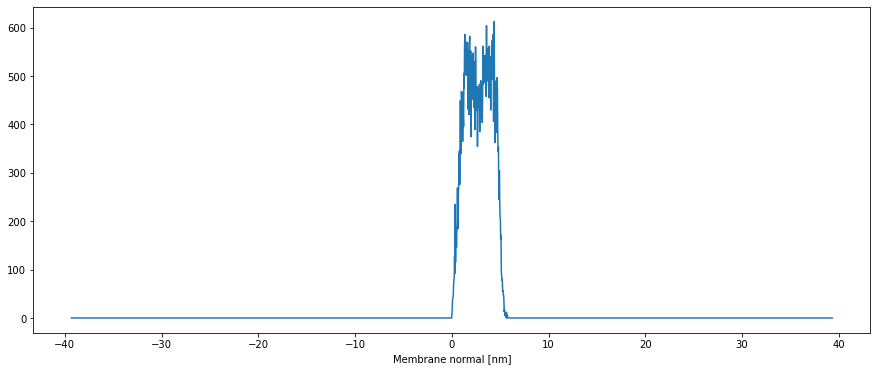

The shape of the density data is (2360, 2)
The index corresponding to 0 in the normal is 1179
The zero point is -0.016672368453724013
The first half is 32461.21733781092
The index after the first half is 1265
The normal coordinate corresponding to this index 2.8509750055862657
The center of mass 28.428849782844452
86
The second half is 31967.957766739317
The index after the second half is 1350
The normal coordinate corresponding to this index 5.685277642718818
86


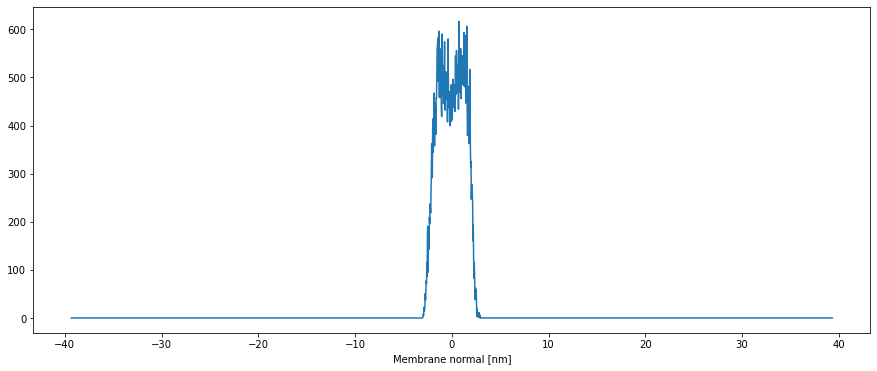

1181
33103.36067635822
30955.018128282718
2360


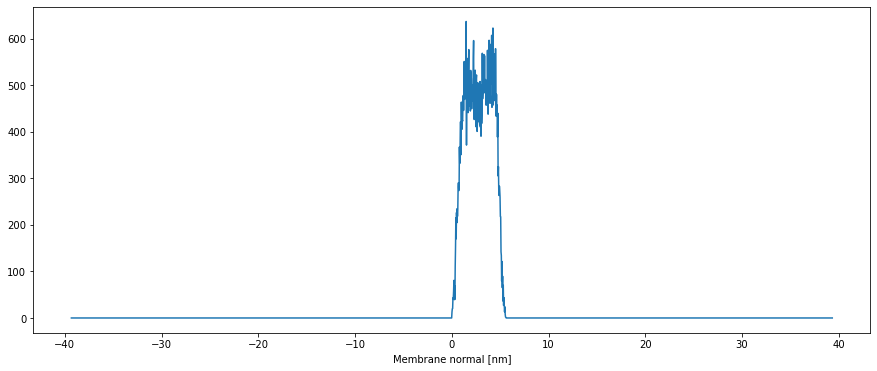

The shape of the density data is (2360, 2)
The index corresponding to 0 in the normal is 1179
The zero point is -0.016672368453724013
The first half is 32621.45770619408
The index after the first half is 1265
The normal coordinate corresponding to this index 2.8509750055862657
The center of mass 28.29381184677688
86
The second half is 32668.07564974721
The index after the second half is 1348
The normal coordinate corresponding to this index 5.618588168903935
84


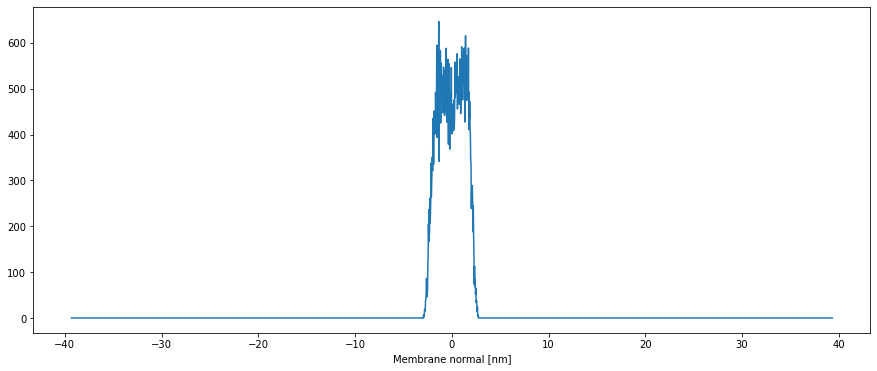

1181
32966.48645885788
31884.99982506513
2360


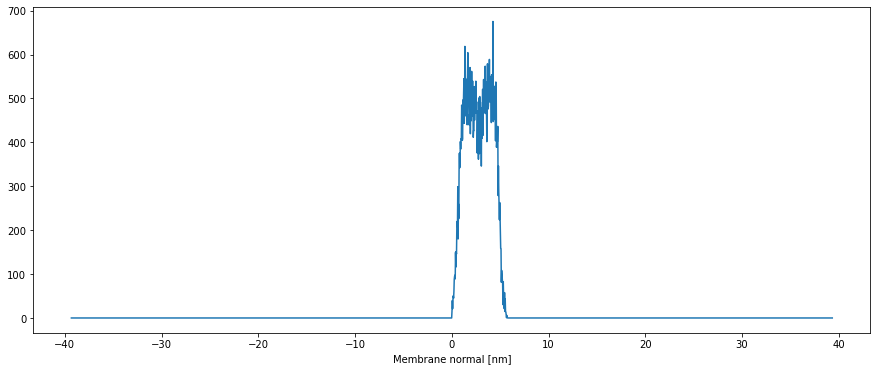

The shape of the density data is (2360, 2)
The index corresponding to 0 in the normal is 1179
The zero point is -0.016672368453724013
The first half is 32475.645373256397
The index after the first half is 1265
The normal coordinate corresponding to this index 2.8509750055862657
The center of mass 28.326597912428305
86
The second half is 31982.59283045658
The index after the second half is 1353
The normal coordinate corresponding to this index 5.785311853441138
89


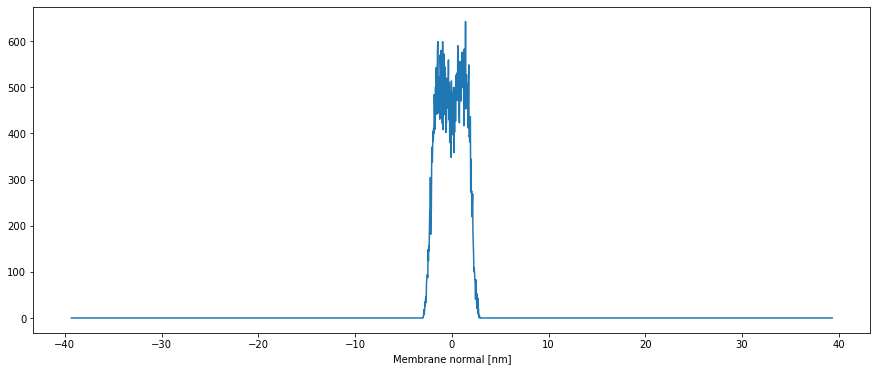

1181
32878.15037156585
31113.271156751158
2360


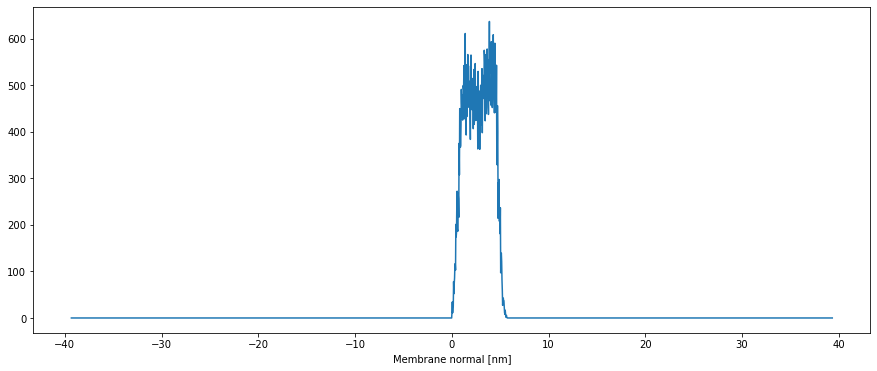

The shape of the density data is (2360, 2)
The index corresponding to 0 in the normal is 1179
The zero point is -0.016672368453724013
The first half is 32239.61558973673
The index after the first half is 1265
The normal coordinate corresponding to this index 2.8509750055862657
The center of mass 28.3722658165443
86
The second half is 31838.0608392922
The index after the second half is 1352
The normal coordinate corresponding to this index 5.7519671165337005
88


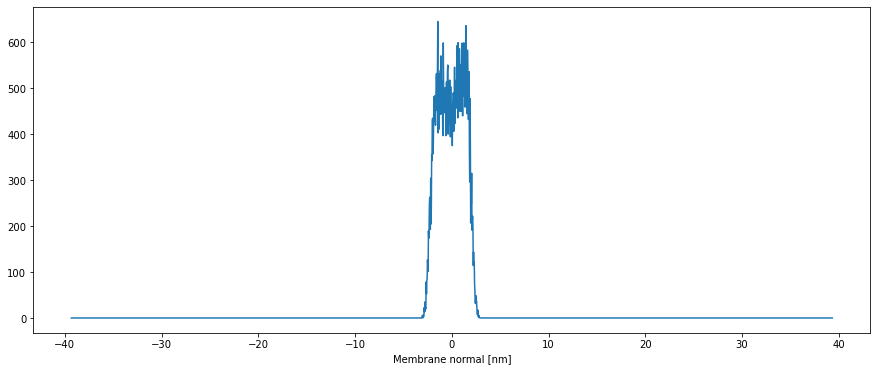

1181
32797.57348241871
30907.129744815204
2360


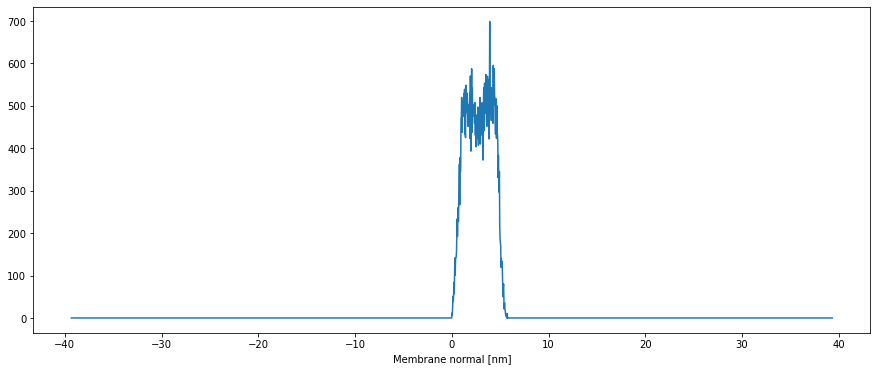

The shape of the density data is (2360, 2)
The index corresponding to 0 in the normal is 1179
The zero point is -0.016672368453724013
The first half is 33671.28862213449
The index after the first half is 1268
The normal coordinate corresponding to this index 2.9510092163085933
The center of mass 29.405490294379515
89
The second half is 31206.623083694187
The index after the second half is 1350
The normal coordinate corresponding to this index 5.685277642718818
83


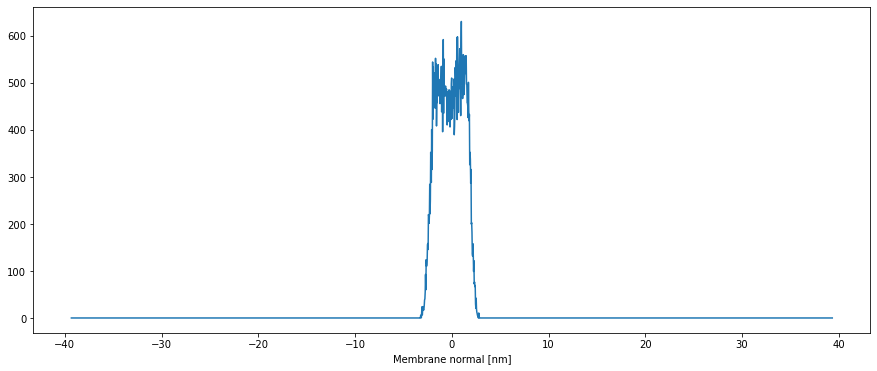

1181
34279.850794860635
30198.199378241447
2360


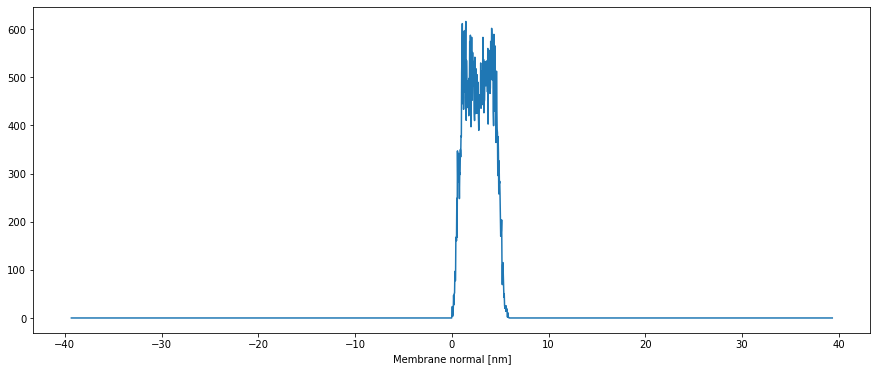

The shape of the density data is (2360, 2)
The index corresponding to 0 in the normal is 1179
The zero point is -0.016672368453724013
The first half is 32388.580059961594
The index after the first half is 1265
The normal coordinate corresponding to this index 2.8509750055862657
The center of mass 28.285564862199145
86
The second half is 32506.68026024741
The index after the second half is 1357
The normal coordinate corresponding to this index 5.918690801070911
93


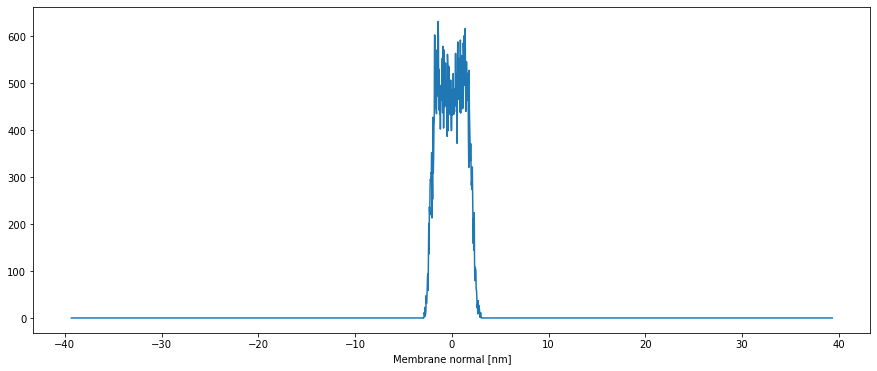

1181
32783.780700372256
31694.90176540647
2360


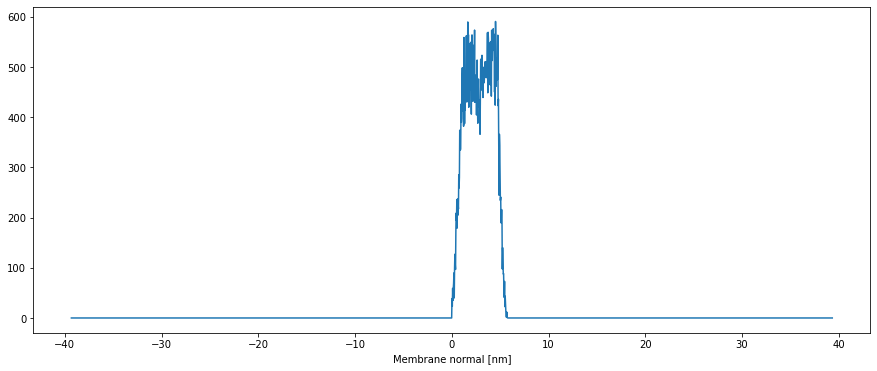

The shape of the density data is (2360, 2)
The index corresponding to 0 in the normal is 1179
The zero point is -0.016672368453724013
The first half is 34292.00258819667
The index after the first half is 1270
The normal coordinate corresponding to this index 3.017698690123476
The center of mass 29.908244050239258
91
The second half is 31975.968479453753
The index after the second half is 1353
The normal coordinate corresponding to this index 5.785311853441138
84


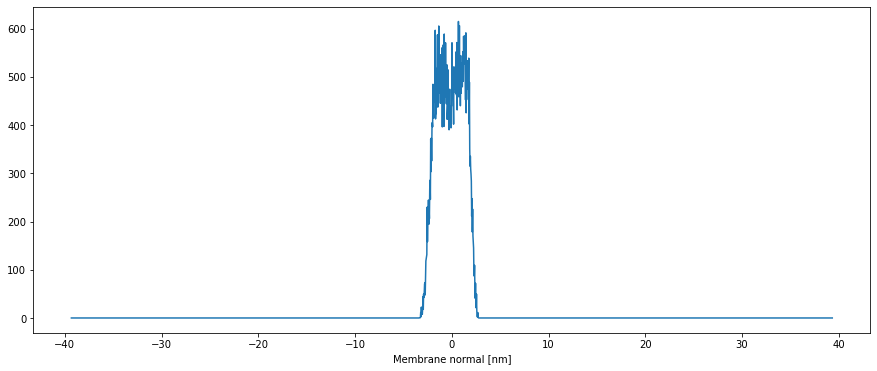

1181
34779.026422506955
31077.957025245898
2360


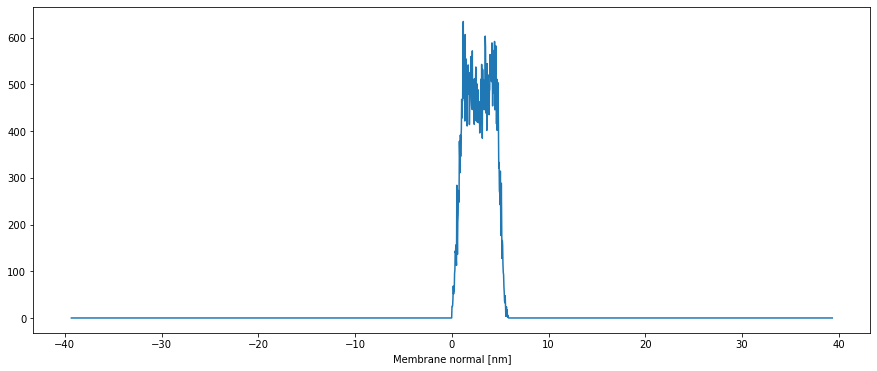

The shape of the density data is (2360, 2)
The index corresponding to 0 in the normal is 1179
The zero point is -0.016672368453724013
The first half is 33175.661357604426
The index after the first half is 1267
The normal coordinate corresponding to this index 2.9176644794011555
The center of mass 28.99618684993689
88
The second half is 32795.51176503013
The index after the second half is 1356
The normal coordinate corresponding to this index 5.885346064163466
90


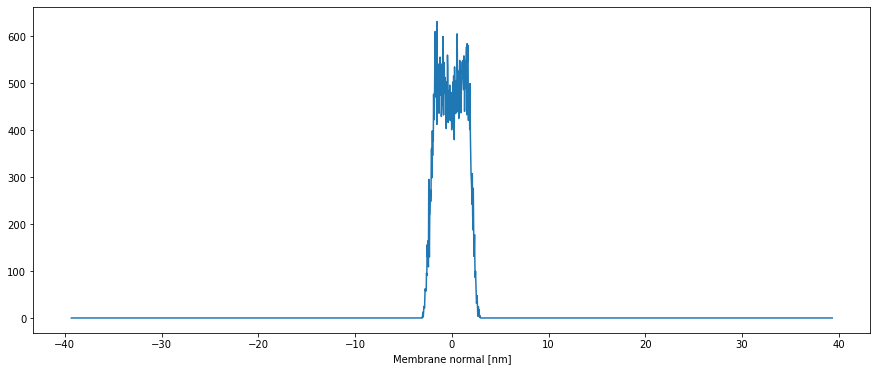

1181
33616.87998463007
31994.879558456836
2360


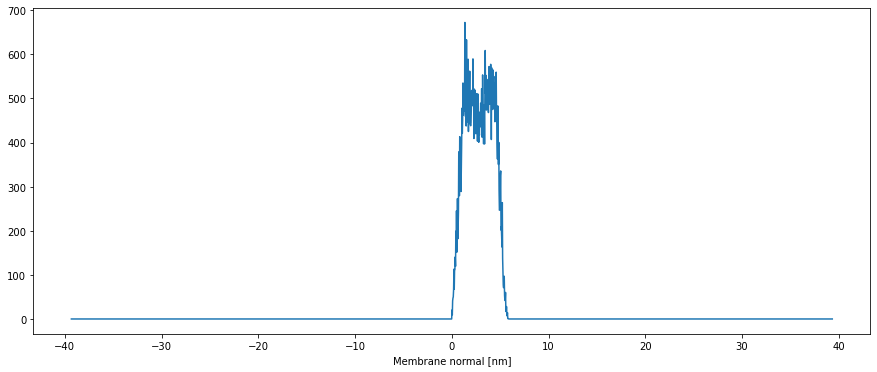

The shape of the density data is (2360, 2)
The index corresponding to 0 in the normal is 1179
The zero point is -0.016672368453724013
The first half is 33659.018922499214
The index after the first half is 1268
The normal coordinate corresponding to this index 2.9510092163085933
The center of mass 29.29840625628474
89
The second half is 32423.28177610721
The index after the second half is 1356
The normal coordinate corresponding to this index 5.885346064163466
89


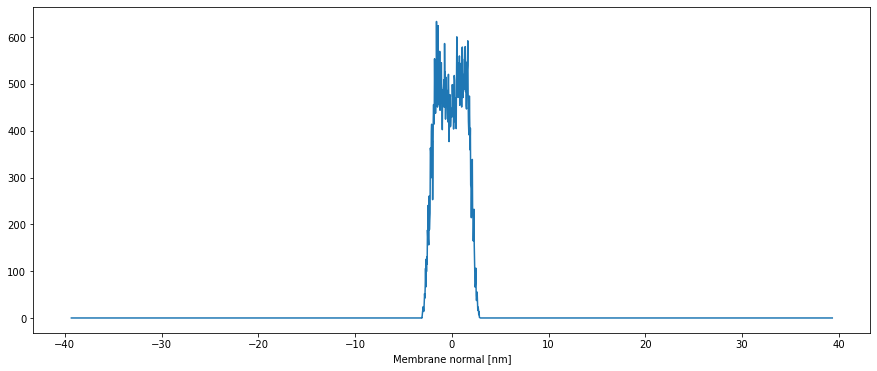

1181
34103.415185568934
31608.502701754613
2360


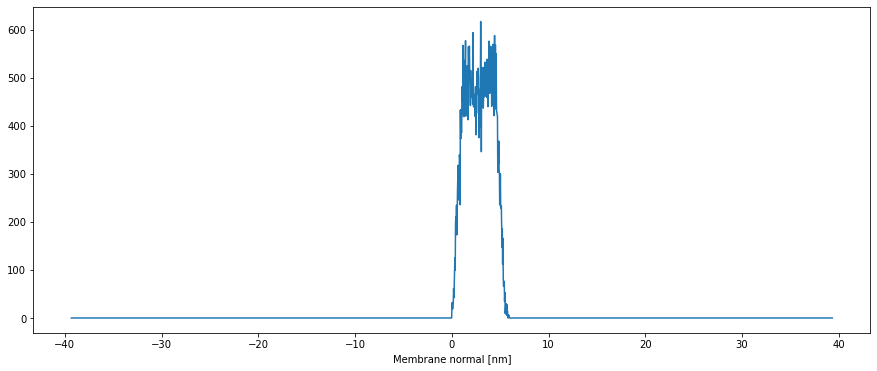

The shape of the density data is (2360, 2)
The index corresponding to 0 in the normal is 1179
The zero point is -0.016672368453724013
The first half is 33928.83499070847
The index after the first half is 1269
The normal coordinate corresponding to this index 2.984353953216038
The center of mass 29.577651560190773
90
The second half is 31486.901912001176
The index after the second half is 1359
The normal coordinate corresponding to this index 5.985380274885793
91


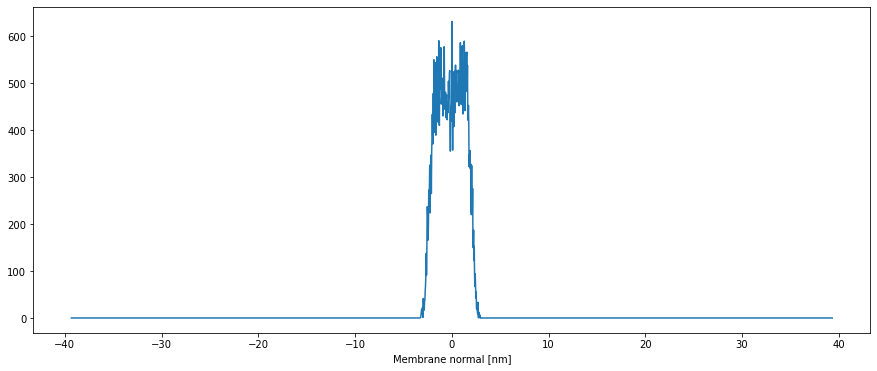

1181
34507.849133215524
30528.96022993208
2360


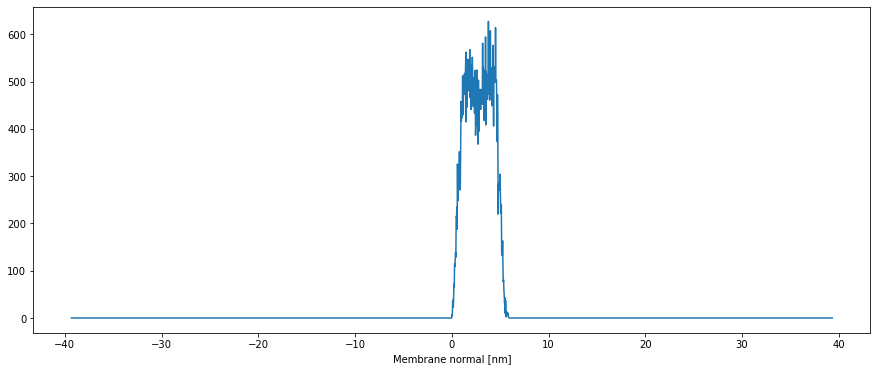

The shape of the density data is (2360, 2)
The index corresponding to 0 in the normal is 1179
The zero point is -0.016672368453724013
The first half is 33131.20755060382
The index after the first half is 1267
The normal coordinate corresponding to this index 2.9176644794011555
The center of mass 28.949340084830123
88
The second half is 32027.115801194144
The index after the second half is 1357
The normal coordinate corresponding to this index 5.918690801070911
91


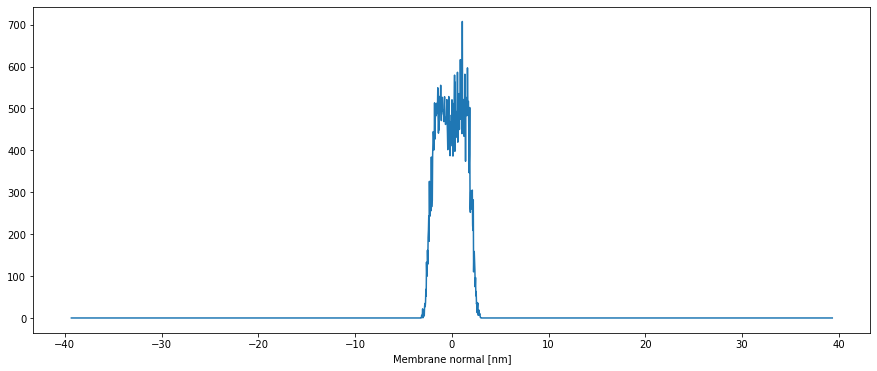

1181
33613.98066078338
31154.185917688083
2360


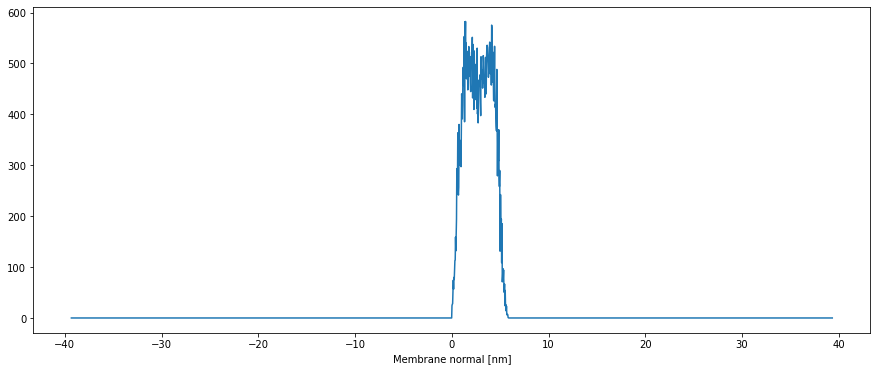

The shape of the density data is (2360, 2)
The index corresponding to 0 in the normal is 1179
The zero point is -0.016672368453724013
The first half is 32812.365403640426
The index after the first half is 1266
The normal coordinate corresponding to this index 2.8843197424937106
The center of mass 28.571929101085434
87
The second half is 31270.259584282747
The index after the second half is 1356
The normal coordinate corresponding to this index 5.885346064163466
91


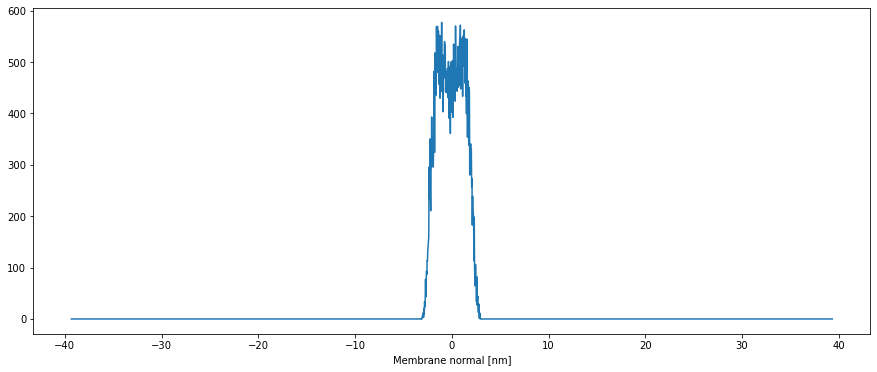

1181
33175.39978201853
30499.317673156227
2360
Calculating the density takes   4.982660 s


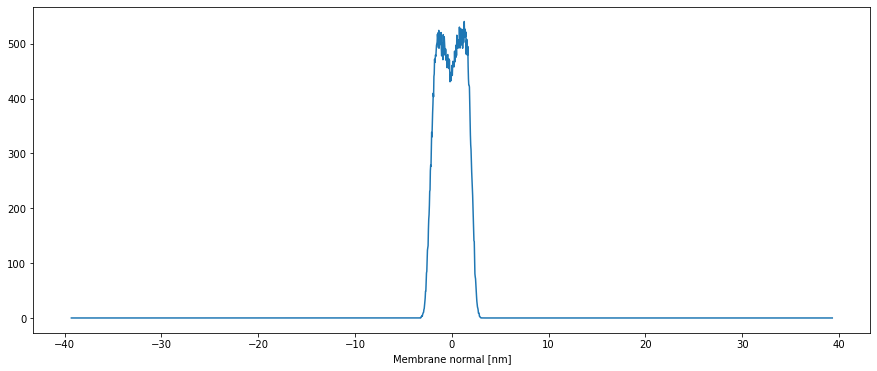

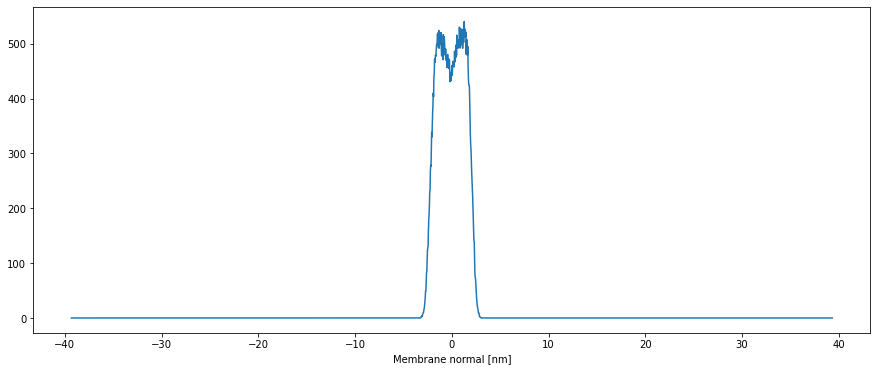

In [50]:
path="/media/nenciric/Ricky20201/2020/simulations/"
name="etidocaine_POPC_CHARMM_298K_Cl_countra_140mM_177600waters_413"

FormFactor(path,name,200,5,name+'_POPC',"resname POPC","resname POPC","mass")

In [20]:
path="/DATA/hector/200POPC_PN_NAs150mM/"
name="PN_model_310K_TIP3P_ECC_ions_154mM_sodium"

topology=path+name+'/'+name+".gro"
trajectory=path+name+'/'+name+".xtc"

Loading the trajectory takes   0.307990 s
Creating the electron mapping dictonary takes   0.000157 s
Calculating the density takes  55.409373 s


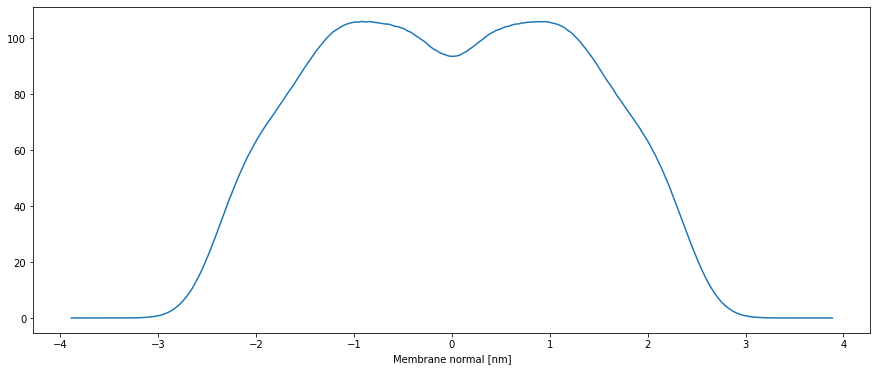

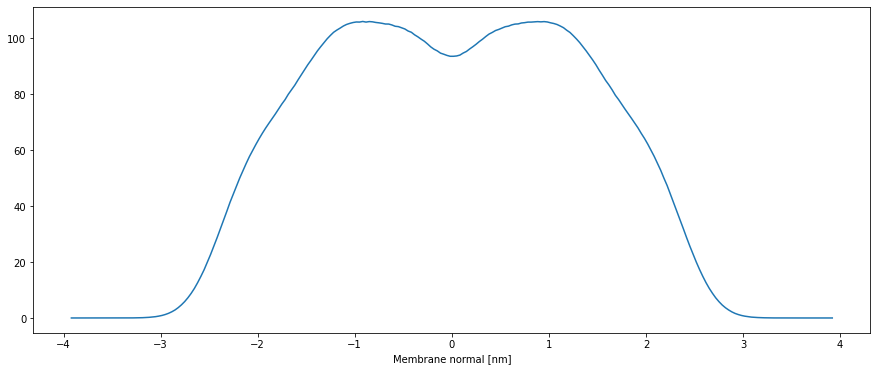

Loading the trajectory takes   0.290520 s
Creating the electron mapping dictonary takes   0.000020 s
Calculating the density takes  36.647547 s


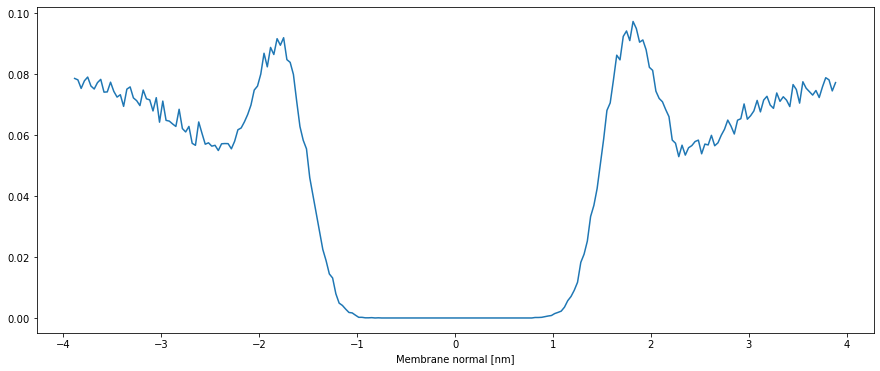

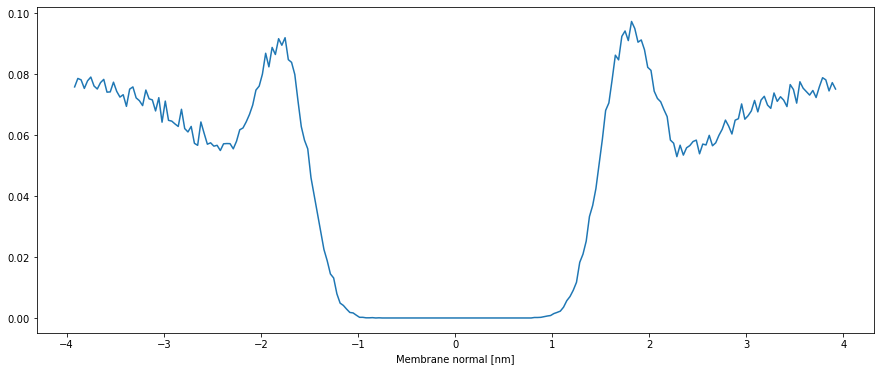

Loading the trajectory takes   0.290982 s
Creating the electron mapping dictonary takes   0.000137 s
Calculating the density takes  55.849168 s


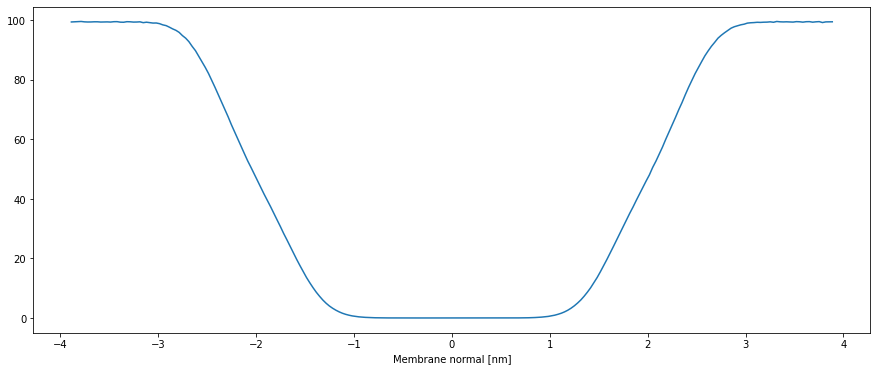

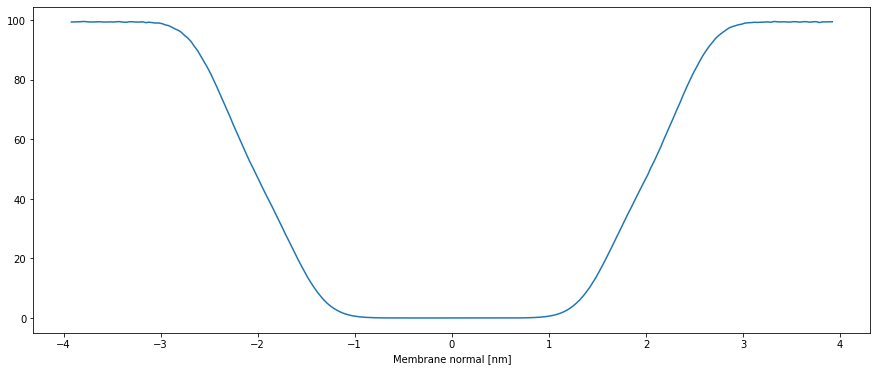

In [21]:
FormFactor(path,name,200,5,'PN_model_310K_TIP3P_ECC_ions_154mM_sodium_PC2',"resname POPC","resname POPC","number")
FormFactor(path,name,200,5,'PN_model_310K_TIP3P_ECC_ions_154mM_sodium_NA2',"resname POPC","resname NA","number")
FormFactor(path,name,200,5,'PN_model_310K_TIP3P_ECC_ions_154mM_sodium_SOL2',"resname POPC","resname SOL","number")

In [88]:
Swiss_140=np.loadtxt("etidocaine_POPC_CHARMM_298K_Cl_countra_140mM_177600waters_413_POPC.finalDensity")
i=0
minus=0
while Swiss_140[i,0]<0:
    minus+=Swiss_140[i,1]
    i+=1

print(i)
plus=0
while i<Swiss_140.shape[0]:
    plus+=Swiss_140[i,1]
    i+=1
    

print(minus)
print(plus)
print(i)

1178
5826.041523460001
5506.2309063799985
2356


In [89]:
Swiss_140.shape[0]

2356

In [27]:
path="/media/nenciric/Ricky20201/2020/simulations/"
name="etidocaine_POPC_CHARMM_298K_Cl_countra_140mM_177600waters_paramchem_simulation2_run2022"

topology=path+name+'/'+name+".gro"
trajectory=path+name+'/'+name+".xtc"

a=mda.Universe(topology,trajectory)


Loading the trajectory takes   3.468120 s
Creating the electron mapping dictonary takes   0.000146 s
Calculating the density takes 969.451460 s


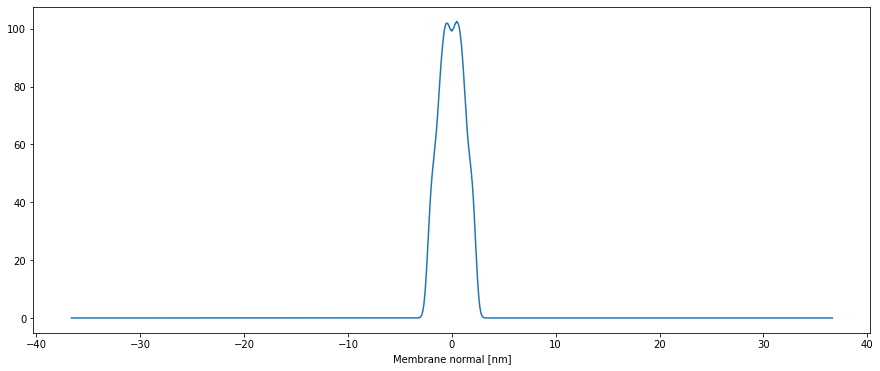

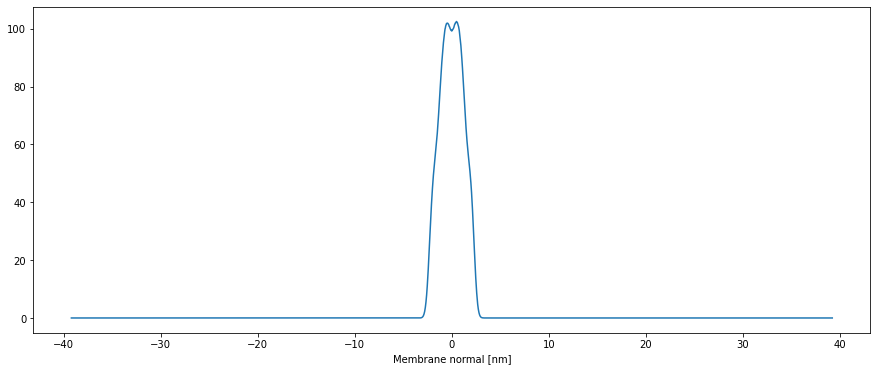

Loading the trajectory takes   3.611421 s
Creating the electron mapping dictonary takes   0.000224 s
Calculating the density takes 918.476283 s


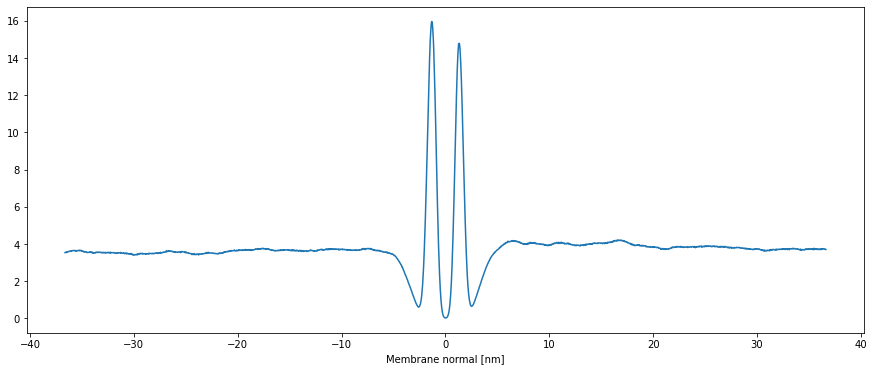

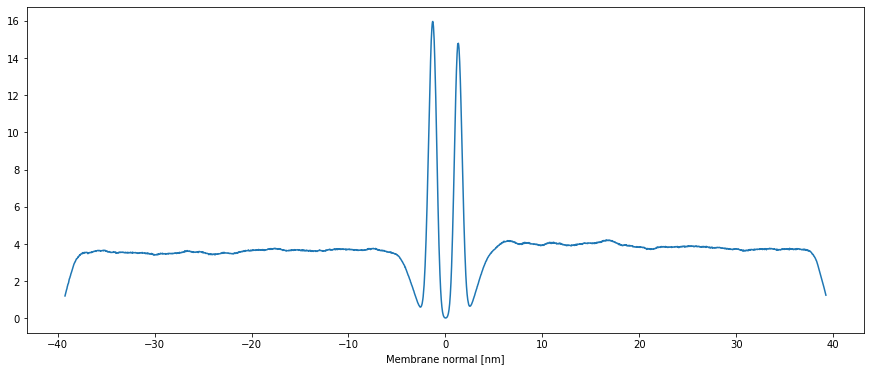

Loading the trajectory takes   3.526145 s
Creating the electron mapping dictonary takes   0.000032 s
Calculating the density takes 904.649840 s


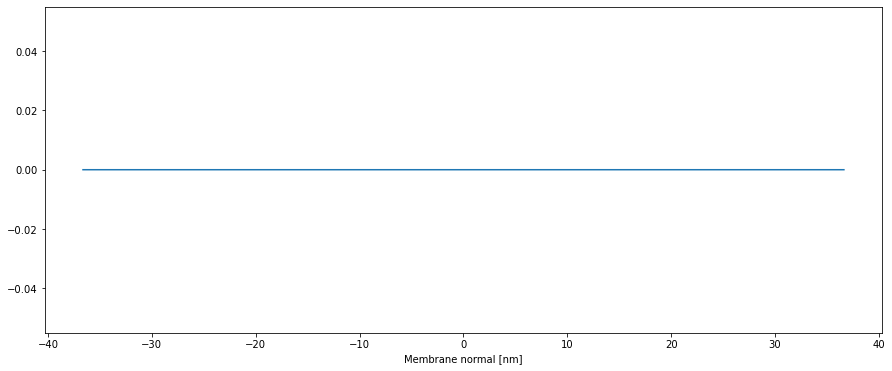

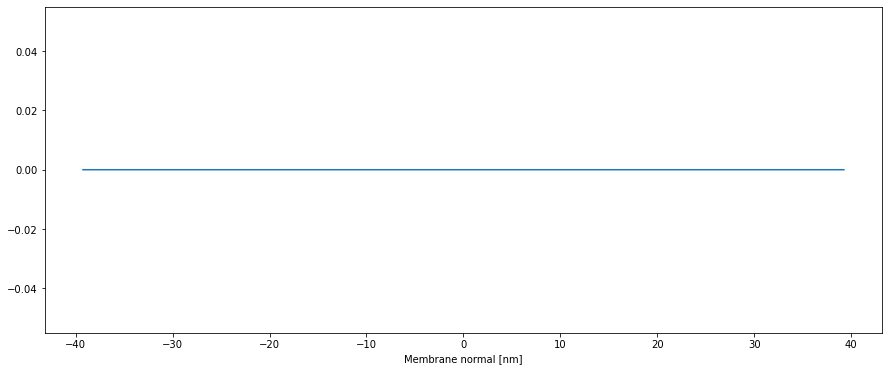

In [34]:
FormFactor(path,name,200,5,name+'_PC',"resname POPC","resname POPC","number")
FormFactor(path,name,200,5,name+'_NA',"resname POPC","resname ETI","number")
FormFactor(path,name,200,5,name+'_SOL',"resname POPC","resname SOL","number")

Loading the trajectory takes   1.137192 s
Creating the electron mapping dictonary takes   0.000265 s
Calculating the density takes 264.538452 s


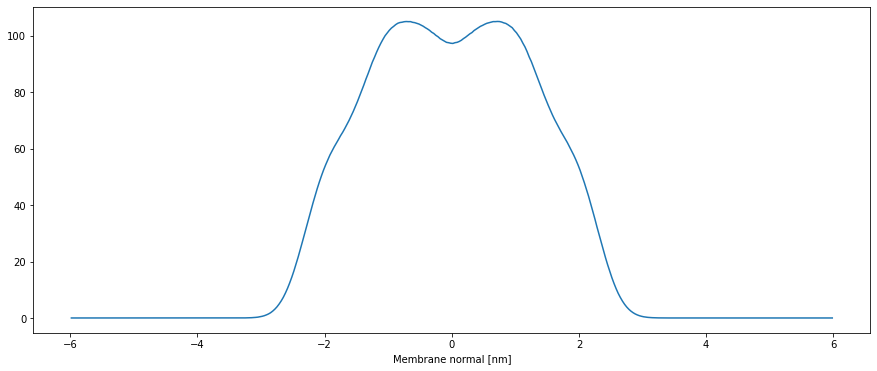

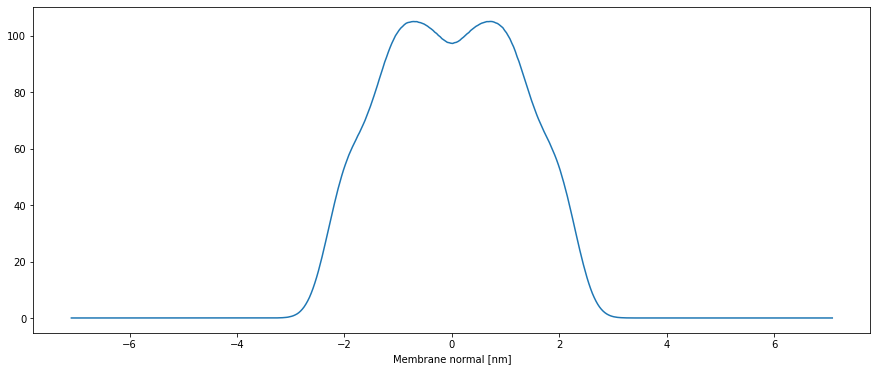

Loading the trajectory takes   0.566558 s
Creating the electron mapping dictonary takes   0.000050 s
Calculating the density takes 153.307214 s


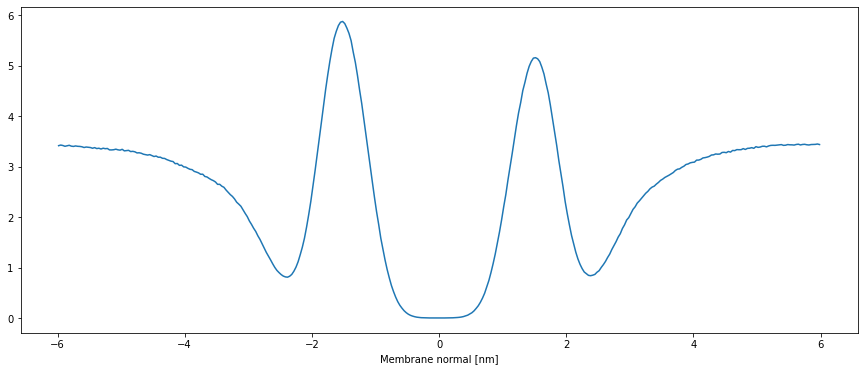

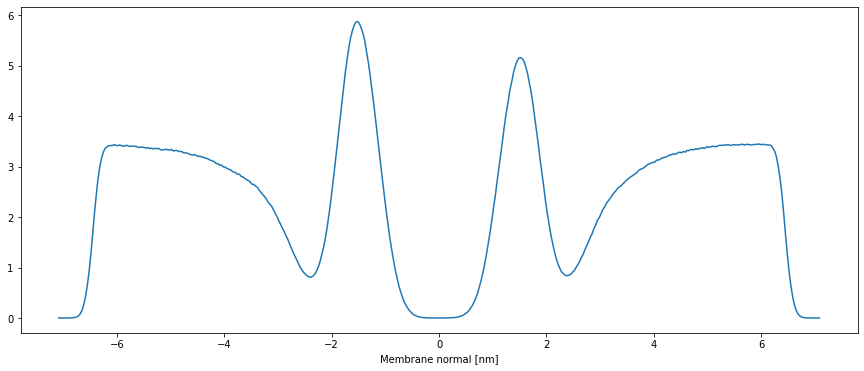

Loading the trajectory takes   0.507940 s
Creating the electron mapping dictonary takes   0.000348 s
Calculating the density takes 278.214947 s


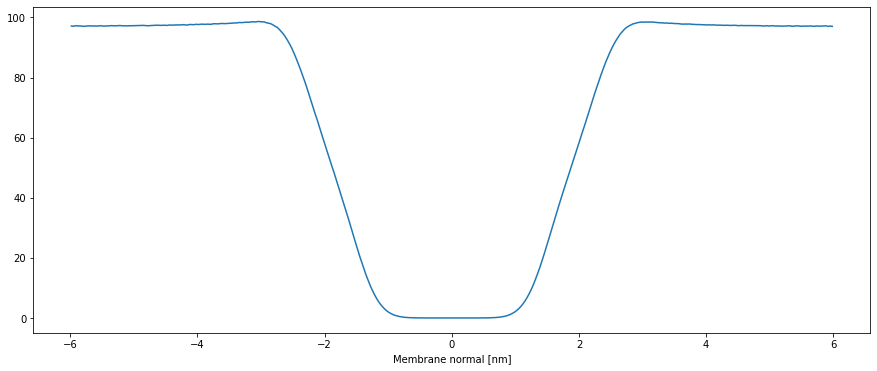

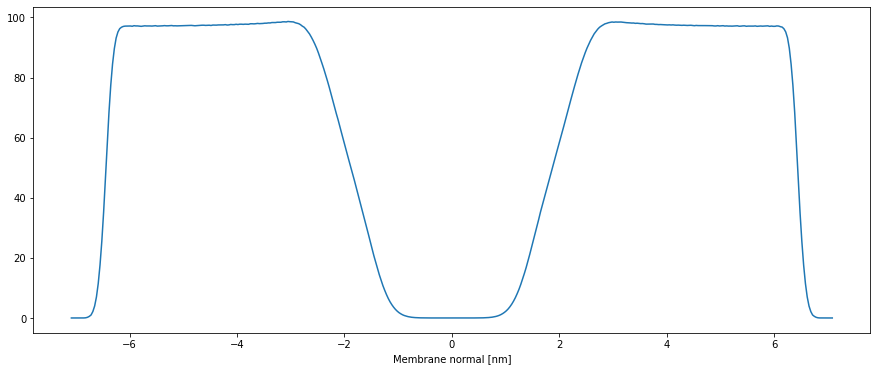

In [23]:
path="/media/nenciric/Ricky2020/simulations/"
name="TPP_POPC_CHARMM36_298K_140mM_20000waters"

FormFactor(path,name,200,5,name+'_PC',"resname POPC","resname POPC","number")
FormFactor(path,name,200,5,name+'_TPA',"resname POPC","resname TPA","number")
FormFactor(path,name,200,5,name+'_SOL',"resname POPC","resname TIP3","number")

Loading the trajectory takes   0.311059 s
Creating the electron mapping dictonary takes   0.000135 s
Calculating the density takes  91.979611 s


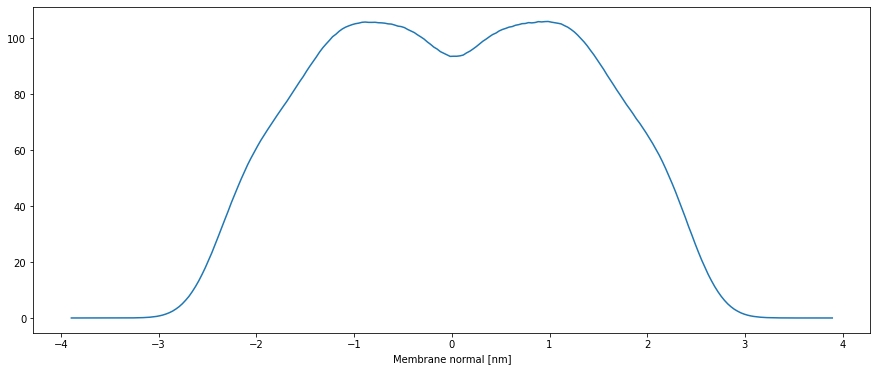

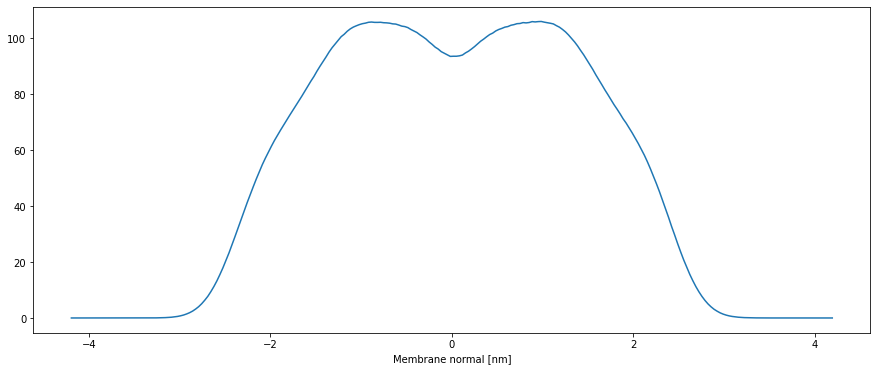

Loading the trajectory takes   0.298935 s
Creating the electron mapping dictonary takes   0.000021 s
Calculating the density takes  72.872091 s


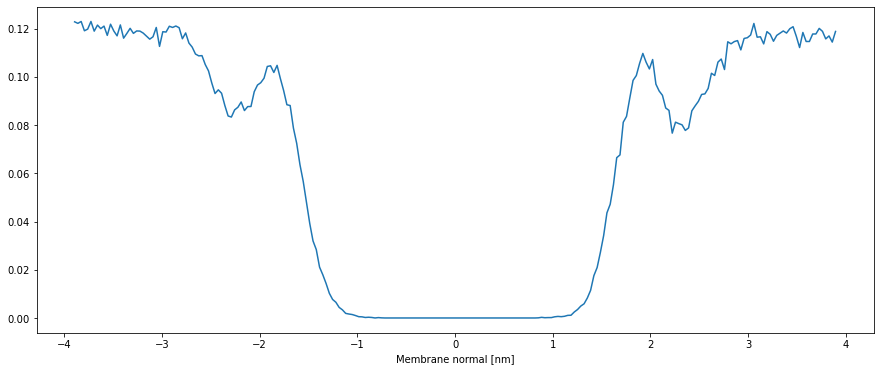

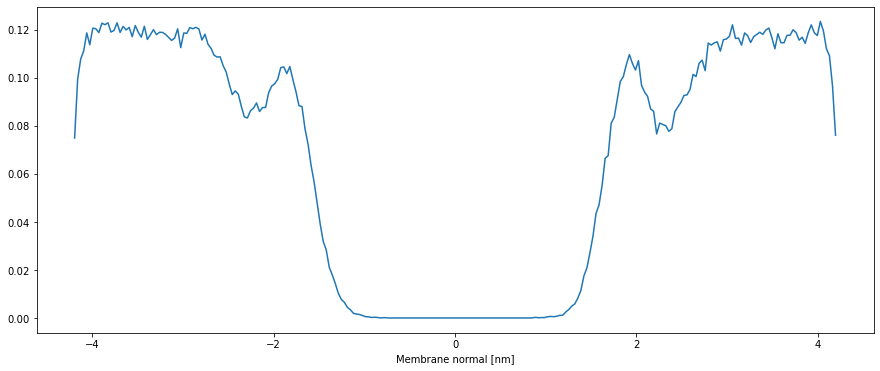

Loading the trajectory takes   0.294087 s
Creating the electron mapping dictonary takes   0.000143 s
Calculating the density takes  94.927795 s


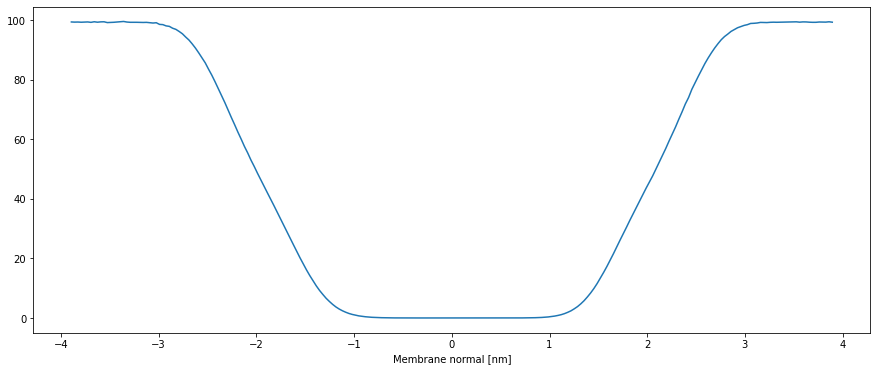

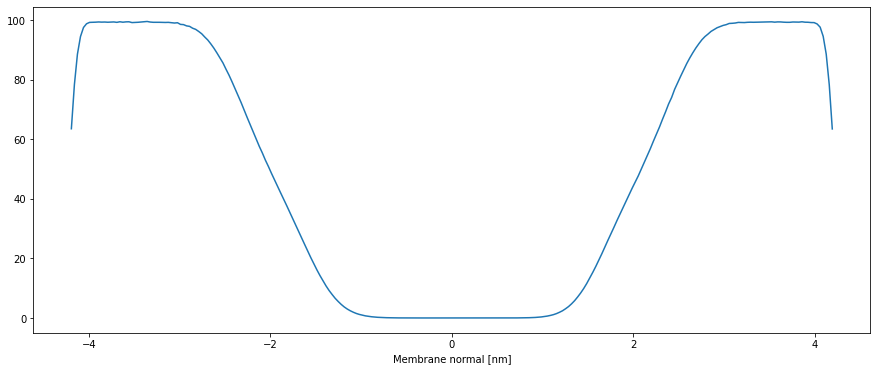

In [47]:
path="/home/nenciric/Downloads/"
name="PN_model_310K_TIP3P_ECC_ions_113mM_calcium"

FormFactor(path,name,200,5,name+'_PC',"resname POPC","resname POPC","number")
FormFactor(path,name,200,5,name+'_CA',"resname POPC","resname CA","number")
FormFactor(path,name,200,5,name+'_SOL',"resname POPC","resname SOL","number")

Loading the trajectory takes   0.467985 s
Creating the electron mapping dictonary takes   0.000173 s
Calculating the density takes  28.278697 s


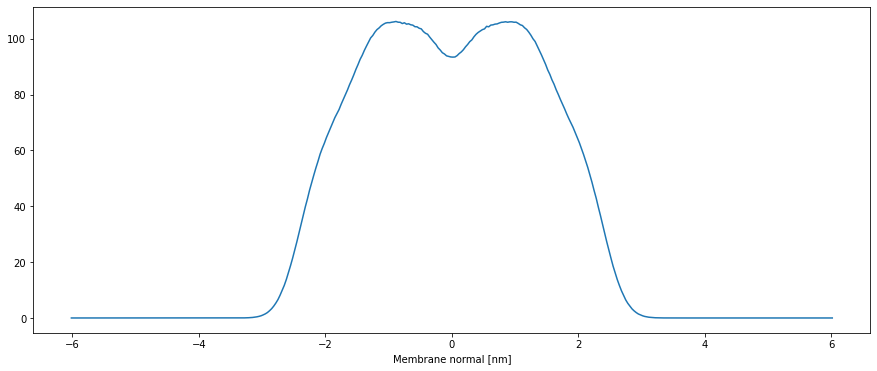

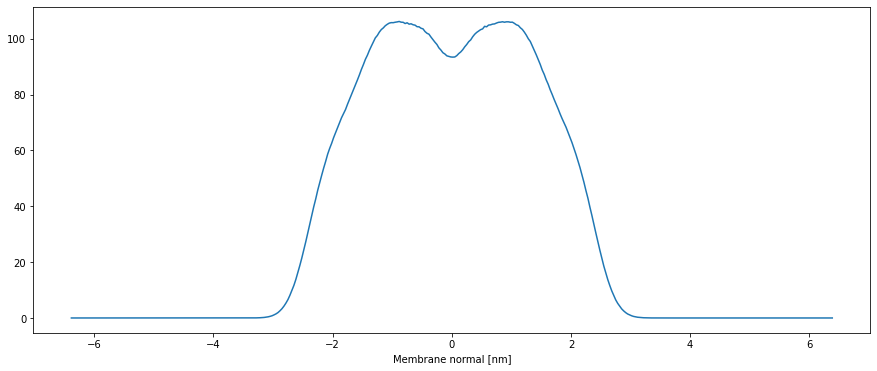

Loading the trajectory takes   0.450389 s
Creating the electron mapping dictonary takes   0.000021 s
Calculating the density takes  21.069886 s


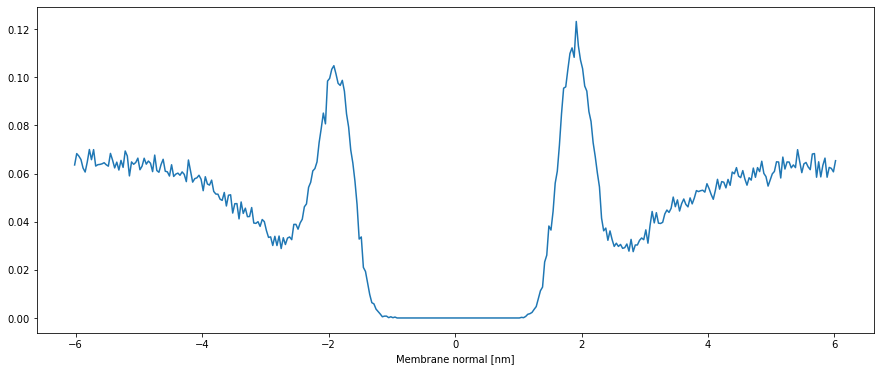

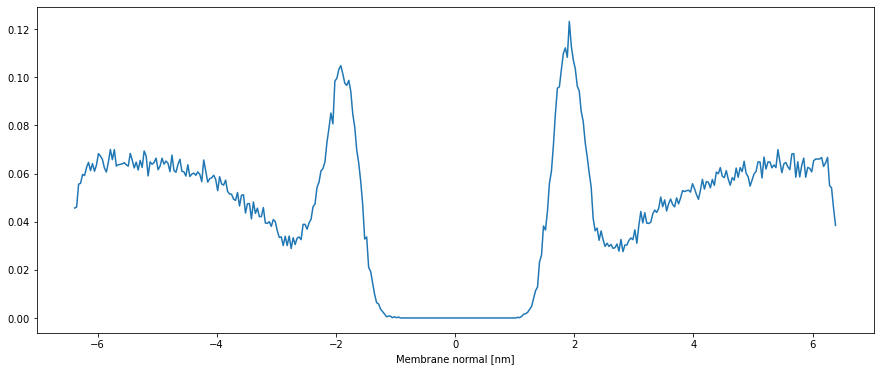

Loading the trajectory takes   0.451218 s
Creating the electron mapping dictonary takes   0.000287 s
Calculating the density takes  37.849131 s


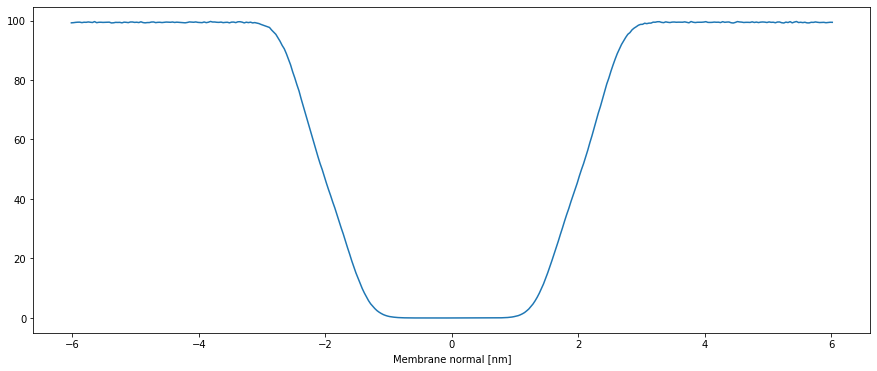

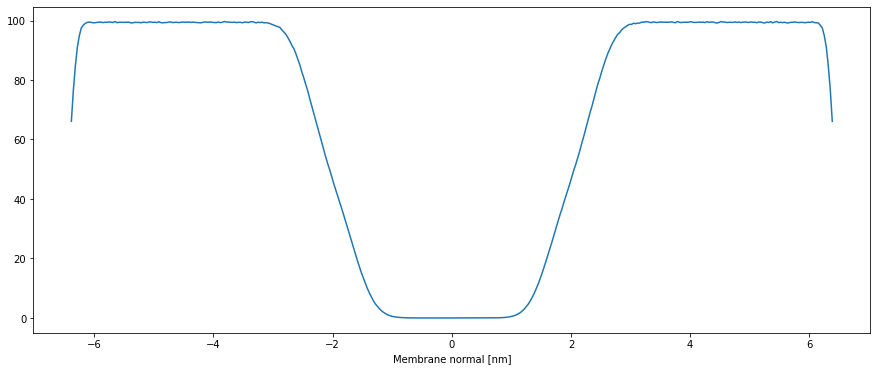

In [51]:
path="/home/nenciric/Downloads/"
name="PN_model_310K_TIP3P_ECC_ions_113mM_calcium_bigBox"

FormFactor(path,name,200,5,name+'_PC',"resname POPC","resname POPC","number")
FormFactor(path,name,200,5,name+'_CA',"resname POPC","resname CA","number")
FormFactor(path,name,200,5,name+'_SOL',"resname POPC","resname SOL","number")

In [42]:
sys.path.insert(1,'/home/nenciric/Documents/git/charged_molecules_binding/simulations_list/')
import AnalysisToolbox as AT
systems=["PN"]

In [48]:
for file in os.listdir(path):
    input_corr_file = path+os.fsdecode(file)
    for system in systems:
        if fnmatch.fnmatch(os.fsdecode(file), "*"+system+"*"):
            newcomer=AT.AnalysisToolbox(path,os.fsdecode(file),system,["ORDER_PARAMETER","BOX_DIMENSIONS"])
            newcomer.add_new_folders()
            #newcomer.analysis_module()


<Universe with 53854 atoms>
Got into checking
/home/nenciric/Downloads/
great success!!!
<Universe with 80908 atoms>
Got into checking
/home/nenciric/Downloads/
great success!!!
